# Pipeline for High-z Radio Galaxies 01: Star/No-star classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

***

## Reading data

We import our data using the `pandas` package.

In [3]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [4]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag',\
                     'FUVmag', 'NUVmag', 'num_imputed'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [5]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [6]:
# full_catalog_df.describe()

#### Select only spectroscopically confirmed sources: stars, galaxies, and AGN

In [7]:
np.unique(full_catalog_df.loc[:, 'spCl'])

array(['      ', 'GALAXY', 'QSO   ', 'STAR  '], dtype=object)

In [8]:
full_catalog_df = full_catalog_df.loc[full_catalog_df.loc[:, 'spCl'] != '      ']

Inverse calculation of star presence, for selecting those which are not stars.

In [9]:
full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)

In [10]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_str = np.sum(full_catalog_df.loc[:, 'is_str'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, {n_is_gal} are identified as galaxies,\n' +\
          f'and {n_is_str} are stars.')

In this dataset, with 81059 elements,
17310 of them are marked as AGN, 55158 are identified as galaxies,
and 6770 are stars.


---

## Possible correlations

In [11]:
print(full_catalog_df.columns.to_list())

['spCl', 'band_num', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

Create target

$0$ for galaxies and $1$ for AGN

In [12]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

## Split data: Test, Train, Validation

In [13]:
target_feat = 'is_str'

In [14]:
train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               target_feat, use_calibration=use_calibration)

print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (81059, 85)
Data for Modeling (Train, Test, and Calibration): (64847, 85)
Training data:                                    (51877, 85)
Testing data:                                     (6485, 85)
Calibration data:                                 (6485, 85)
Validation data:                                  (16212, 85)
------------------------------------------------------------



Save indices of sources in validation sub-set for future steps.

In [15]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

Remove intermediate targets

In [16]:
cols_2_drop_class = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'spCl']
full_catalog_df = full_catalog_df.drop(columns=cols_2_drop_class)
train_test_df   = train_test_df.drop(columns=cols_2_drop_class)
train_df        = train_df.drop(columns=cols_2_drop_class)
test_df         = test_df.drop(columns=cols_2_drop_class)
validation_df   = validation_df.drop(columns=cols_2_drop_class)

---

## Use Correlation matrix to discard some features

In [17]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [18]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [19]:
rsd_vals

is_str        331.261176
z_y           209.631823
i_z           197.325184
y_W2          164.249822
z_W2          119.314962
i_y           117.016772
y_W1          114.426534
r_i           105.902880
z_W1           93.322054
i_W2           92.525022
g_r            90.148678
r_z            84.541764
i_W1           78.847127
r_y            75.744354
H_W3           72.711426
r_W2           70.719142
g_i            68.619300
r_W1           67.512783
g_z            64.922241
g_y            62.011154
g_W1           56.242935
J_W3           54.604669
g_W2           54.476617
y_J            49.869464
y_H            45.411484
J_H            44.972118
W1_W3          44.854321
z_J            44.705407
z_H            41.122484
i_J            41.001923
y_W3           40.034383
y_K            39.897943
r_J            39.134831
i_H            38.018288
z_W3           36.967886
z_K            36.802204
r_H            36.798739
H_K            36.182517
g_J            34.846969
i_K            34.665140


In [20]:
correlation = norm_train_test_df.corr()

In [21]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [22]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [23]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [24]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [25]:
list_drop_corr

['g_H',
 'r_H',
 'i_H',
 'y_H',
 'z_H',
 'gmag',
 'rmag',
 'J_W1',
 'imag',
 'ymag',
 'zmag',
 'g_K',
 'J_W2',
 'r_K',
 'W1mproPM',
 'i_K',
 'z_K',
 'y_K',
 'W2mproPM',
 'g_W4',
 'H_W1',
 'r_W4',
 'K_W1',
 'J_W3',
 'i_W4',
 'y_W4',
 'Jmag',
 'z_W4',
 'H_W2',
 'g_W2',
 'J_W4',
 'K_W2',
 'g_W3',
 'W1_W4',
 'r_W3',
 'r_W1',
 'W3mag',
 'i_W3',
 'y_W3',
 'z_W3',
 'W2_W4',
 'i_W1',
 'z_W1',
 'Hmag',
 'y_W1',
 'g_y',
 'W2_W3',
 'J_K',
 'z_J',
 'g_z',
 'z_W2',
 'K_W3',
 'r_J',
 'i_J',
 'r_W2',
 'K_W4',
 'i_W2',
 'g_J',
 'H_W4',
 'r_y',
 'band_num',
 'g_i',
 'y_J']

In [26]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [27]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [28]:
corr_discard = norm_train_test_discard.corr()

In [29]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

is_str  is_str    1.000000
r_z     r_i       0.723591
W1_W3   W1_W2     0.636611
i_y     i_z       0.591643
g_W1    r_z       0.586502
z_y     i_y       0.559611
W1_W2   g_W1      0.547949
W3_W4   H_W3      0.541252
g_r     g_W1      0.541174
H_K     Kmag      0.530747
r_z     i_z       0.520831
g_W1    r_i       0.502606
W1_W3   H_K       0.447766
Kmag    H_W3      0.445631
W1_W2   r_z       0.425327
dtype: float64

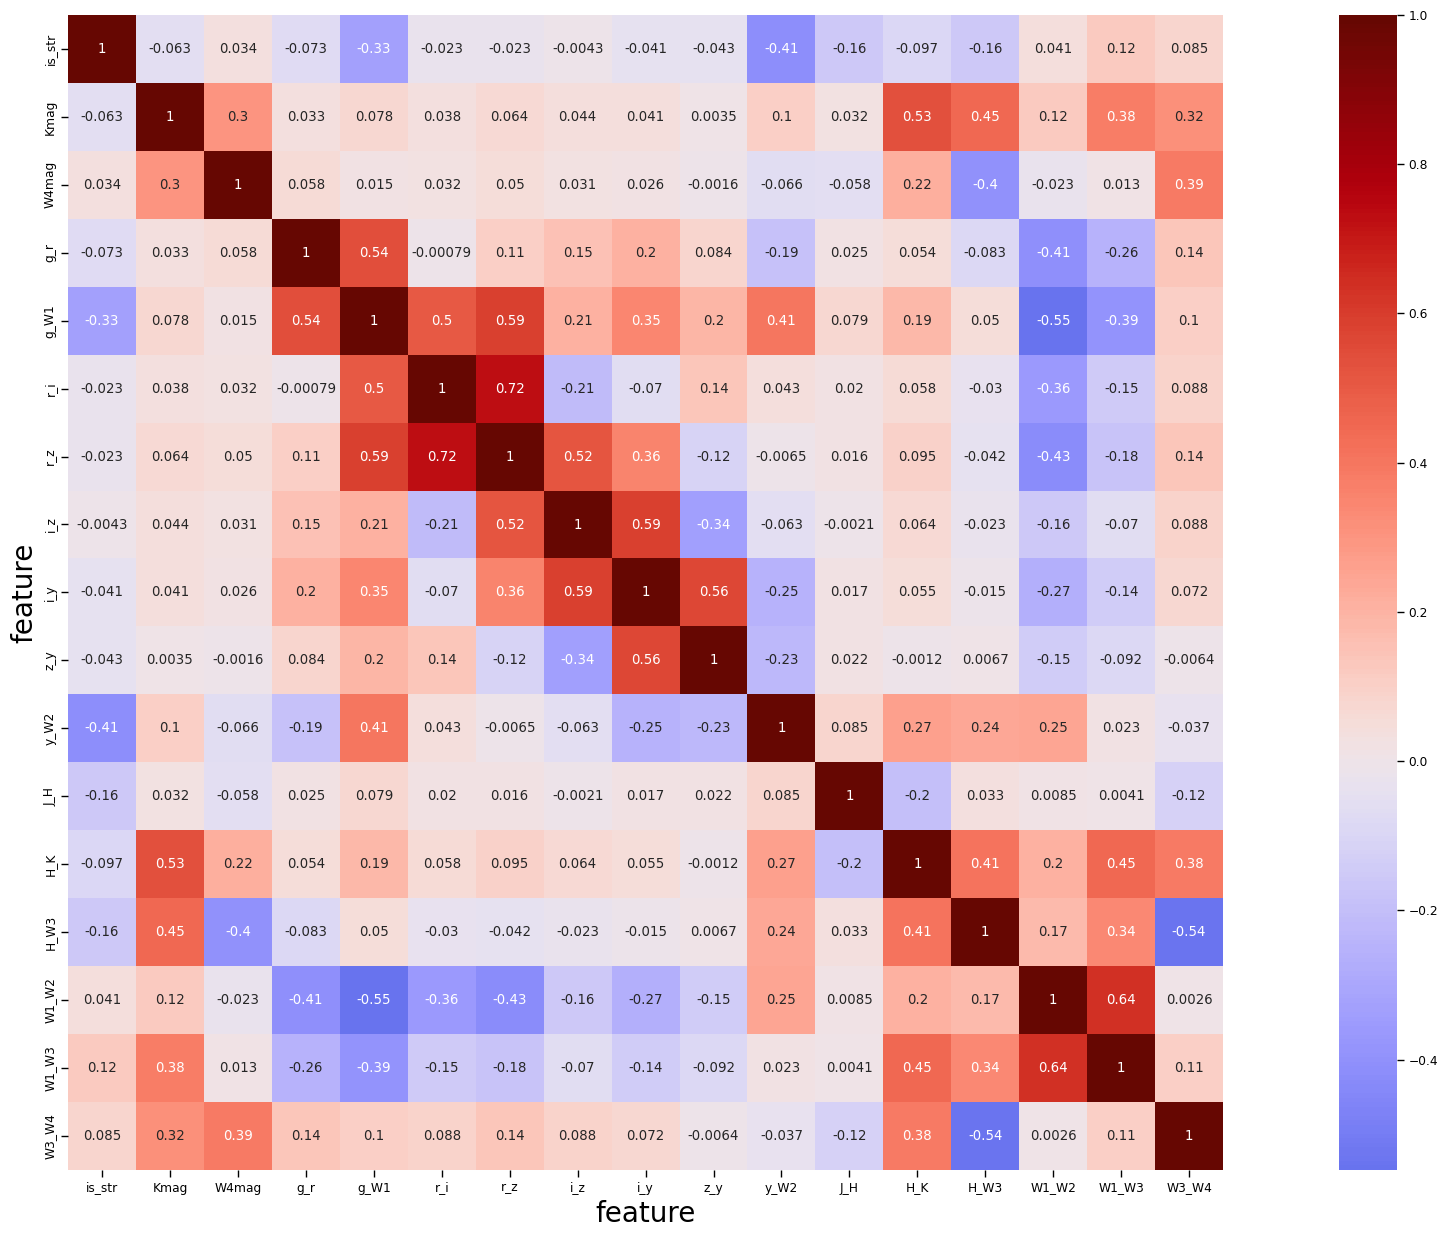

In [30]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [31]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [32]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [33]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x       y    
H_K     H_K      1.000000
H_W3    W3_W4    0.464071
        H_K      0.412258
r_i     r_z      0.375340
r_z     r_i      0.371191
J_H     H_K      0.284014
W1_W2   W1_W3    0.263612
W1_W3   W1_W2    0.257349
g_r     g_W1     0.201365
r_z     g_W1     0.179665
z_y     i_y      0.127721
r_i     g_W1     0.127608
r_z     g_r      0.121436
r_i     g_r      0.115809
g_r     r_i      0.115012
W1_W2   g_W1     0.097705
g_r     r_z      0.090819
g_W1    W1_W2    0.087438
i_z     r_z      0.074617
is_str  y_W2     0.071918
dtype: float64

In [34]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [35]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [36]:
list_drop_pps = []

In [37]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [38]:
list_drop_pps

[]

In [39]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [40]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [41]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,g_W1,is_str,0.052077,classification,True,weighted F1,0.886917,0.892806,DecisionTreeClassifier()
1,y_W2,is_str,0.051186,classification,True,weighted F1,0.886917,0.892705,DecisionTreeClassifier()
2,H_K,is_str,0.036875,classification,True,weighted F1,0.886917,0.891087,DecisionTreeClassifier()
3,H_W3,is_str,0.019595,classification,True,weighted F1,0.886917,0.889133,DecisionTreeClassifier()
4,Kmag,is_str,0.002661,classification,True,weighted F1,0.886917,0.887218,DecisionTreeClassifier()
5,W4mag,is_str,0.000000,classification,True,weighted F1,0.886917,0.886518,DecisionTreeClassifier()
6,g_r,is_str,0.000000,classification,True,weighted F1,0.886917,0.870465,DecisionTreeClassifier()
7,r_i,is_str,0.000000,classification,True,weighted F1,0.886917,0.874326,DecisionTreeClassifier()
8,r_z,is_str,0.000000,classification,True,weighted F1,0.886917,0.875755,DecisionTreeClassifier()
9,i_z,is_str,0.000000,classification,True,weighted F1,0.886917,0.875390,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### Star Detection Prediction

In [42]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [43]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [44]:
exp_str = pyc.setup(data=train_df, test_data=test_df, target=target_feat, session_id=gv.seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,is_str
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(51877, 80)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [45]:
pyc.get_config('X').columns

Index(['Kmag', 'W4mag', 'g_r', 'g_W1', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y',
       'y_W2', 'J_H', 'H_K', 'H_W3', 'W1_W2', 'W1_W3', 'W3_W4'],
      dtype='object')

In [46]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [47]:
metric_to_optimize    = 'Recall'

In [48]:
final_selection_clf   = ['catboost', 'xgboost', 'et', 'gbc', 'rf', 'dummy']  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_str = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
# top_model_str = pyc.compare_models(n_select=n_models, exclude=['knn', 'qda'], sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9791,0.9811,0.8062,0.9348,0.8656,0.8544,0.8572,2.0120
xgboost,Extreme Gradient Boosting,0.9782,0.9802,0.8015,0.9276,0.8599,0.8481,0.8508,8.3540
et,Extra Trees Classifier,0.9779,0.9727,0.7845,0.9406,0.8552,0.8433,0.8475,0.2290
rf,Random Forest Classifier,0.9780,0.9740,0.7822,0.9454,0.8559,0.8441,0.8487,0.8440
gbc,Gradient Boosting Classifier,0.9716,0.9676,0.7113,0.9332,0.8071,0.7921,0.8007,1.7900
dummy,Dummy Classifier,0.9165,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0170


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [49]:
stacked_model_str = pyc.stack_models(estimator_list=top_model_str[1:], meta_model=top_model_str[0],\
                                     optimize=metric_to_optimize, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9757,0.9802,0.7765,0.9208,0.8425,0.8294,0.8330
1,0.9807,0.9808,0.8203,0.9418,0.8768,0.8664,0.8689
2,0.9753,0.9752,0.7834,0.9091,0.8416,0.8283,0.8310
3,0.9813,0.9886,0.8499,0.9200,0.8836,0.8734,0.8742
4,0.9790,0.9825,0.8129,0.9263,0.8659,0.8546,0.8567
5,0.9780,0.9795,0.8060,0.9208,0.8596,0.8477,0.8500
6,0.9836,0.9821,0.8476,0.9508,0.8962,0.8874,0.8891
7,0.9784,0.9805,0.8014,0.9303,0.8610,0.8494,0.8522
8,0.9792,0.9790,0.8176,0.9243,0.8676,0.8564,0.8583


In [50]:
tuned_str_clf = pyc.tune_model(stacked_model_str, early_stopping=True, optimize=metric_to_optimize,\
                               search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9749,0.9799,0.7627,0.9246,0.8359,0.8224,0.8269
1,0.9798,0.9823,0.7972,0.9532,0.8683,0.8574,0.8614
2,0.9753,0.9766,0.7926,0.9005,0.8431,0.8298,0.8318
3,0.9817,0.9891,0.8430,0.9311,0.8848,0.8749,0.8762
4,0.9798,0.9817,0.8106,0.9385,0.8699,0.8590,0.8617
5,0.9776,0.9809,0.8014,0.9204,0.8568,0.8447,0.8471
6,0.9823,0.9843,0.8383,0.9429,0.8875,0.8779,0.8797
7,0.9798,0.9820,0.8060,0.9432,0.8692,0.8583,0.8615
8,0.9801,0.9770,0.8106,0.9435,0.8720,0.8614,0.8643


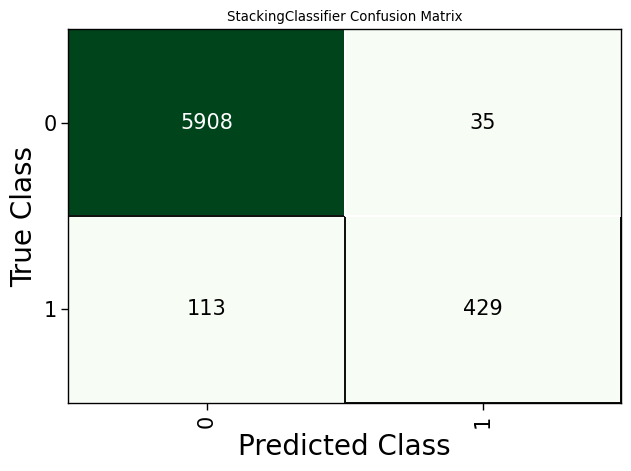

In [51]:
pyc.plot_model(tuned_str_clf, plot='confusion_matrix')

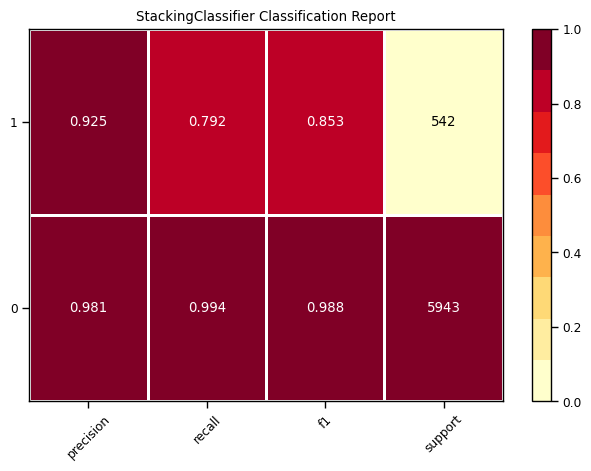

In [52]:
pyc.plot_model(tuned_str_clf, plot='class_report')

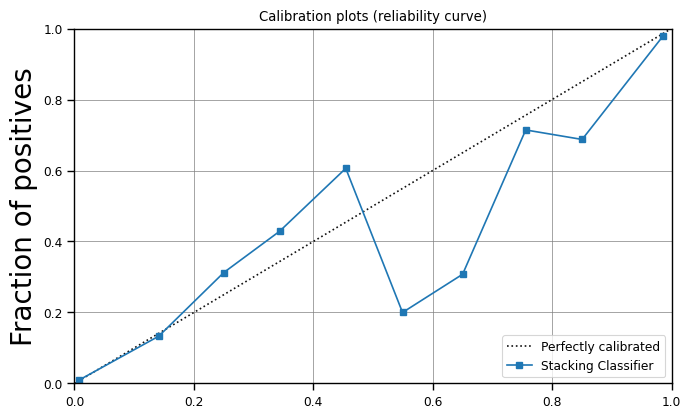

In [53]:
pyc.plot_model(tuned_str_clf, plot='calibration')

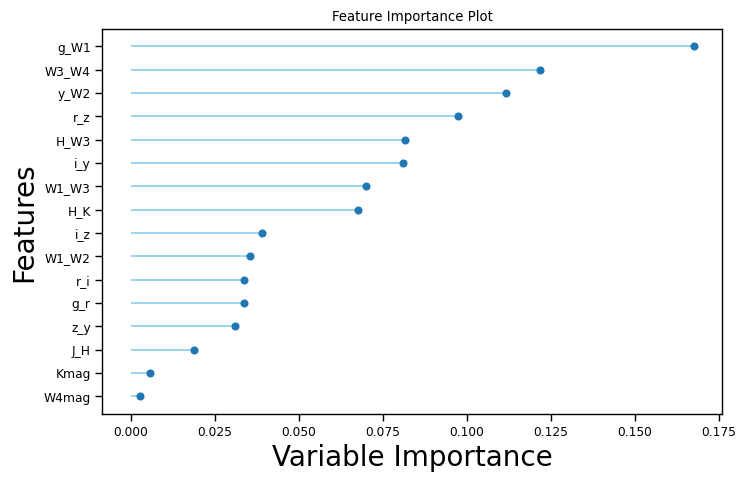

In [54]:
pyc.plot_model(tuned_str_clf.estimators_[0], plot='feature_all')

In [55]:
pyc.plot_model(tuned_str_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [56]:
pyc.plot_model(tuned_str_clf.final_estimator, plot='parameter')

,Parameters
border_count,254
thread_count,12
verbose,False
task_type,CPU
random_state,42


In [57]:
plt.rcParams.update(plt.rcParamsDefault)

In [58]:
pyc.predict_model(tuned_str_clf, probability_threshold=gv.naive_star_thresh, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9772,0.9835,0.7915,0.9246,0.8529,0.8406,0.8436


,Score_0,Score_1
count,6485.000000,6485.000000
mean,0.917439,0.082561
std,0.248264,0.248264
min,0.000100,0.000000
25%,0.987900,0.000600
50%,0.997600,0.002400
75%,0.999400,0.012100
max,1.000000,0.999900


In [59]:
test_prediction_clf = pyc.predict_model(tuned_str_clf, probability_threshold=gv.naive_star_thresh, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9772,0.9835,0.7915,0.9246,0.8529,0.8406,0.8436


In [60]:
final_str_clf = pyc.finalize_model(tuned_str_clf)

In [61]:
pyc.predict_model(final_str_clf, probability_threshold=gv.naive_star_thresh, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9772,0.9835,0.7915,0.9246,0.8529,0.8406,0.8436


,Score_0,Score_1
count,6485.000000,6485.000000
mean,0.917439,0.082561
std,0.248264,0.248264
min,0.000100,0.000000
25%,0.987900,0.000600
50%,0.997600,0.002400
75%,0.999400,0.012100
max,1.000000,0.999900


In [62]:
if save_model_flag:
    pyc.save_model(final_str_clf, gv.models_path + gv.star_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [45]:
if load_model_flag:
    final_str_clf = pyc.load_model(gv.models_path + gv.star_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [46]:
base_models_names = gf.get_base_estimators_names(final_str_clf)
base_models       = gf.get_base_estimators_models(final_str_clf)

In [47]:
print('Running data pre-processing:\n')
extended_data_str_df = gf.preprocess_data(final_str_clf, validation_df, base_models_names)

Running data pre-processing:



In [48]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_str_clf, extended_data_str_df)

In [49]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_str_df)

In [50]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [51]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for et...
Calculating for rf...
Calculating for gbc...


xgboost                 et                 rf                gbc           
   Feature Importance Feature Importance Feature Importance Feature Importance
0     g_W1  16.774849    y_W2  21.107086    y_W2  20.142564    g_W1  32.108604
1    W3_W4  12.177494    g_W1  16.200560    g_W1  18.433100    y_W2  20.206931
2     y_W2  11.181874     r_z   9.522628     r_z   9.921401     r_z  16.525622
3      r_z   9.736092     r_i   7.383930     r_i   8.300616     i_y   9.988898
4     H_W3   8.172815     i_y   6.838345     i_y   7.509121   W1_W3   4.955317
5      i_y   8.095209   W1_W3   6.658728     i_z   7.184539     g_r   3.237222
6    W1_W3   7.012407     g_r   6.561167     g_r   6.600632     r_i   3.007741
7      H_K   6.756227   W1_W2   6.314080     z_y   6.041062     i_z   2.802903
8      i_z   3.899169     i_z   6.061852   W1_W2   5.301420   W1_W2   2.433182
9    W1_W2   3.550674     z_y   5.287234   W1_W3   4.853983     z_y   1.759378
10     r_i   3.391941     J_H   2.108527     H_K   1.848580    H_W3   1.195105
11     g_r   3.387040    H_W3   1.923272    H_W3   1.510549   W3_W4   1.061252
12     z_y   3.123555     H_K   1.806919     J_H   1.475634     H_K   0.558176
13     J_H   1.885899   W3_W4   1.490664   W3_W4   0.766707     J_H   0.159670
14    Kmag   0.587312    Kmag   0.501398    Kmag   0.079598    Kmag   0.000000
15   W4mag   0.267447   W4mag   0.233608   W4mag   0.030493   W4mag   0.000000

In [52]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,gbc,27.490655
1,rf,7.446686
2,xgboost,6.232643
3,et,6.076805
4,g_r,6.050967
5,i_z,5.779502
6,W1_W3,5.496376
7,W1_W2,5.182510
8,r_i,4.884411
9,y_W2,4.546648


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
g_W1	20.879
y_W2	18.160
r_z	11.426
i_y	8.108
W1_W3	5.870
r_i	5.521
i_z	4.987
g_r	4.947
W1_W2	4.400
z_y	4.053
W3_W4	3.874
H_W3	3.200
H_K	2.742
J_H	1.407
Kmag	0.292
W4mag	0.133


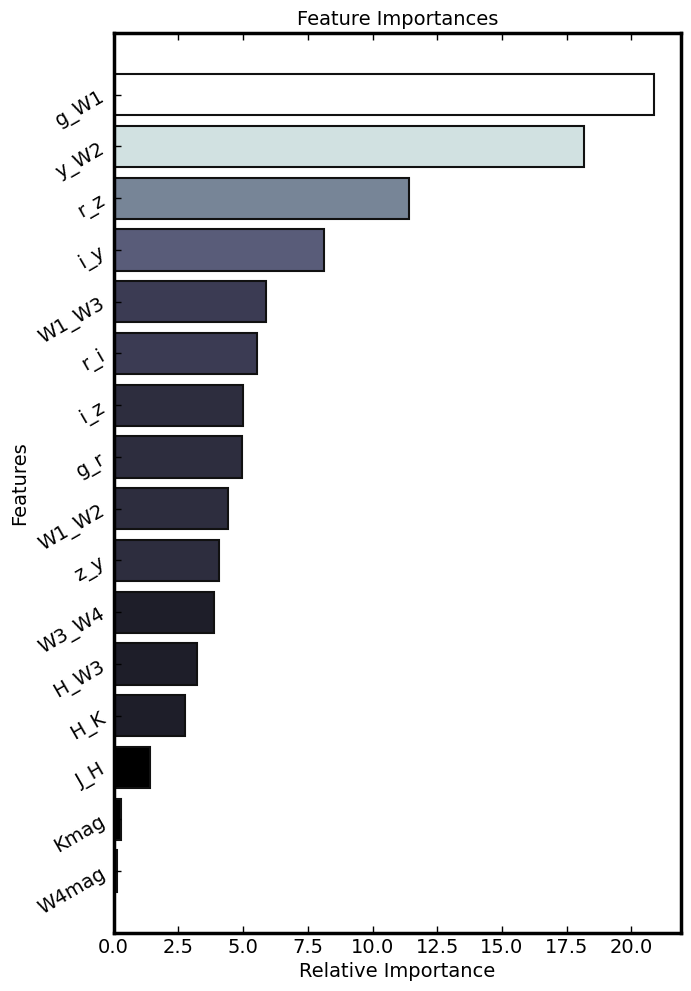

In [53]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = gf.get_feature_importances_df(final_str_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_star_no_star_01.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [54]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_str_clf, 'catboost', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,catboost,xgboost,et,rf,gbc
learning_rate,0.0556,0.3000,NaN,NaN,0.1000
depth,6.0000,NaN,NaN,NaN,NaN
random_strength,1.0000,NaN,NaN,NaN,NaN
l2_leaf_reg,3.0000,NaN,NaN,NaN,NaN
n_estimators,NaN,100,100,100,100
subsample,NaN,1.0000,NaN,NaN,1.0000
max_depth,NaN,6.0000,NaN,NaN,3.0000
colsample_bytree,NaN,1.0000,NaN,NaN,NaN
min_child_weight,NaN,1.0000,NaN,NaN,NaN
reg_alpha,NaN,0.0000,NaN,NaN,NaN


---

In [55]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 51,877
Size of test set is  6,485


#### Calculate optimal threshold for classification

In [56]:
validation_prediction_clf = pyc.predict_model(final_str_clf, data=validation_df, probability_threshold=gv.naive_star_thresh, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_str_clf, data=train_df,      probability_threshold=gv.naive_star_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_str_clf, data=test_df,       probability_threshold=gv.naive_star_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_str_clf, data=calibration_df, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_str_clf, data=train_test_df, probability_threshold=gv.naive_star_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9826054774,0.9865485334,0.8485967504,0.9371941272,0.8906976744,0.8812738022,0.8825562595


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9930797849,0.9982805753,0.9176090468,0.9994972348,0.9568042354,0.9530502872,0.9540790666


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9771781033,0.9835236717,0.7915129151,0.9245689655,0.8528827038,0.8405928383,0.8435750847


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9807247494,0.9848260288,0.8207024030,0.9406779661,0.8766041461,0.8662026101,0.8685747708


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9902539825,0.9958521093,0.8953101920,0.9867724868,0.9388189739,0.9335378285,0.9348413950


#### Naive threshold metrics.

In [57]:
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])

In [58]:
MCC_train_naive         = gf.MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = gf.ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = gf.F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = gf.Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = gf.MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = gf.ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = gf.F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = gf.Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = gf.MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = gf.ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = gf.F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = gf.Recall_from_CM(cm_mat_train_test_naive)

MCC_calib_naive       = gf.MCC_from_CM(cm_mat_calib_naive)
ACC_calib_naive       = gf.ACC_from_CM(cm_mat_calib_naive)
F1_calib_naive        = gf.F1_from_CM(cm_mat_calib_naive)
Recall_calib_naive    = gf.Recall_from_CM(cm_mat_calib_naive)

MCC_val_naive           = gf.MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = gf.ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = gf.F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = gf.Recall_from_CM(cm_mat_val_naive)


naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_calib_naive,      MCC_calib_naive,      Recall_calib_naive,      ACC_calib_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [59]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'],\
                               index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'])

In [60]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df)

,F1,MCC,Recall,ACC
Train,0.9568,0.9541,0.9176,0.9931
Test,0.8529,0.8436,0.7915,0.9772
Train+Test,0.9388,0.9348,0.8953,0.9903
Calibration,0.8766,0.8686,0.8207,0.9807
Validation,0.8907,0.8826,0.8486,0.9826


#### Calibration curve

In [61]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

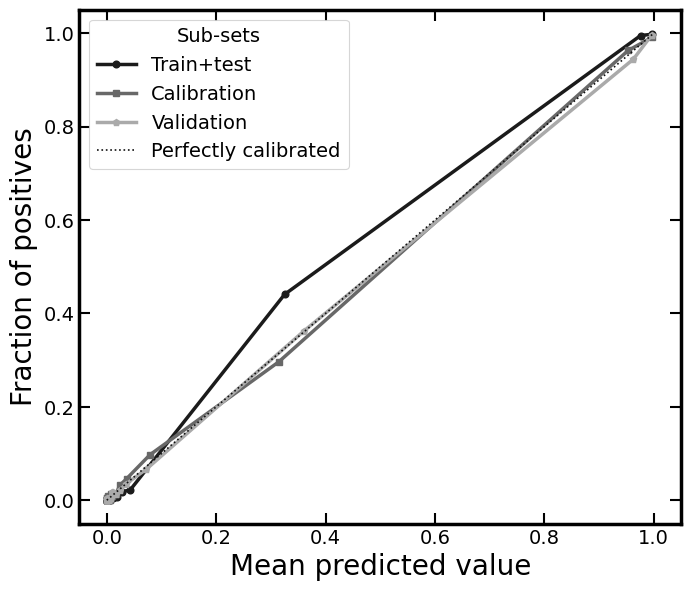

In [62]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_star_no_star.pdf', bbox_inches='tight')
plt.show()

Calculate ROC AUC values and plots.

In [63]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [64]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99828
Area under the curve (ROC) for test       = 0.98352
Area under the curve (ROC) for train+test = 0.99585
Area under the curve (ROC) for calibraton = 0.99585
Area under the curve (ROC) for validation = 0.98655


In [65]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

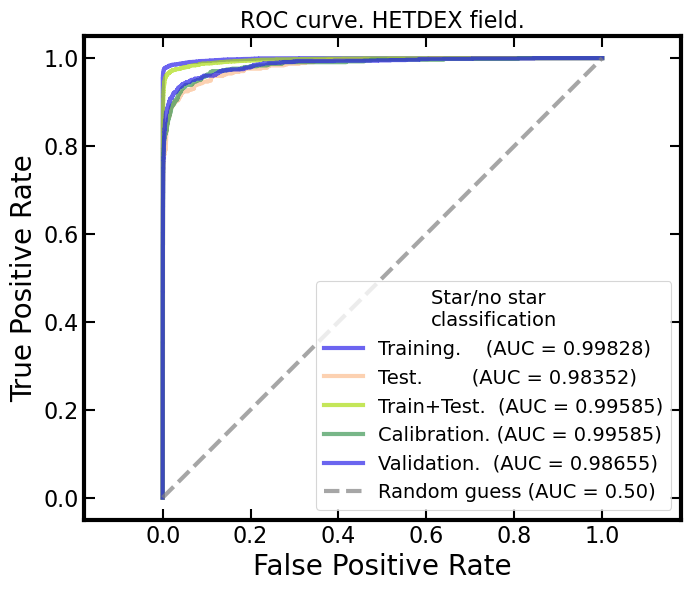

In [66]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='Star/no star\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [67]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_calib      = thresh_train_test[np.argmax(tpr_calib - fpr_calib)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [68]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_t_calib:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training    = 0.09841
Optimal threshold from area under the curve (ROC) for test        = 0.06583
Optimal threshold from area under the curve (ROC) for train+test  = 0.09697
Optimal threshold from area under the curve (ROC) for calibration = 0.49107
Optimal threshold from area under the curve (ROC) for validation  = 0.08459


##### Precision-Recall curve

In [69]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [70]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

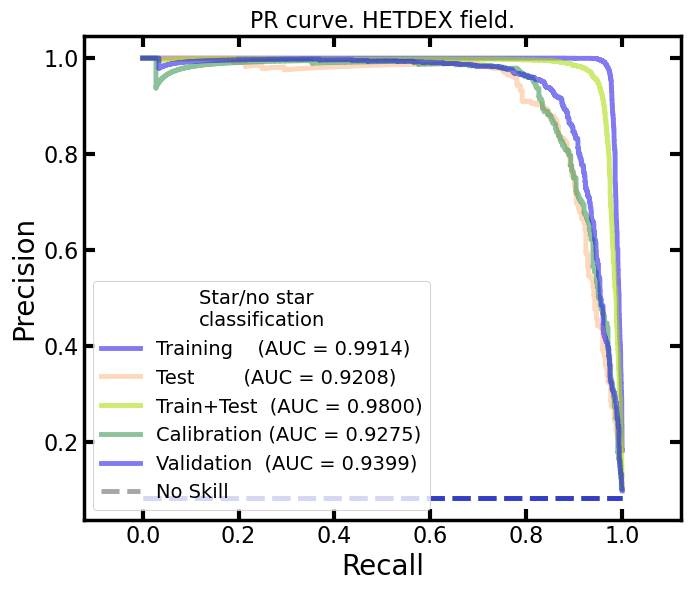

In [71]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=3.0)
ax1.tick_params(which='minor', length=4, width=3.0)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Star/no star\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [72]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_calib      = (2 * prec_calib      * recall_calib)      / (prec_calib      + recall_calib)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [73]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [74]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training    = 0.18517
Optimal threshold from Precision-Recall curve for test        = 0.29318
Optimal threshold from Precision-Recall curve for train+test  = 0.26115
Optimal threshold from Precision-Recall curve for calibration = 0.60307
Optimal threshold from Precision-Recall curve for validation  = 0.36932


---

In [75]:
str_pred_threshold = float(opt_t_PR_train_test) #  0.26115

In [76]:
validation_prediction_clf = pyc.predict_model(final_str_clf, data=validation_df,  probability_threshold=str_pred_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_str_clf, data=train_df,       probability_threshold=str_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_str_clf, data=test_df,        probability_threshold=str_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_str_clf, data=calibration_df, probability_threshold=str_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_str_clf, data=train_test_df,  probability_threshold=str_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9801381693,0.9865485334,0.8862629247,0.8771929825,0.8817046289,0.8708639212,0.8708776480


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9958748578,0.9982805753,0.9533810293,0.9971035482,0.9747522416,0.9725074117,0.9727972581


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9774865073,0.9835236717,0.8634686347,0.8666666667,0.8650646950,0.8527834487,0.8527851828


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9771781033,0.9848260288,0.8558225508,0.8686679174,0.8621973929,0.8497569888,0.8497850129


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9921661758,0.9958521093,0.9346381093,0.9704754601,0.9522197141,0.9479546741,0.9481537370


Create confusion matrix with validation data.

In [77]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [78]:
MCC_str_train         = gf.MCC_from_CM(cm_mat_train)
ACC_str_train         = gf.ACC_from_CM(cm_mat_train)
F1_str_train          = gf.F1_from_CM(cm_mat_train)
Recall_str_train      = gf.Recall_from_CM(cm_mat_train)

MCC_str_test          = gf.MCC_from_CM(cm_mat_test)
ACC_str_test          = gf.ACC_from_CM(cm_mat_test)
F1_str_test           = gf.F1_from_CM(cm_mat_test)
Recall_str_test       = gf.Recall_from_CM(cm_mat_test)

MCC_str_train_test    = gf.MCC_from_CM(cm_mat_train_test)
ACC_str_train_test    = gf.ACC_from_CM(cm_mat_train_test)
F1_str_train_test     = gf.F1_from_CM(cm_mat_train_test)
Recall_str_train_test = gf.Recall_from_CM(cm_mat_train_test)

MCC_str_calib         = gf.MCC_from_CM(cm_mat_calib)
ACC_str_calib         = gf.ACC_from_CM(cm_mat_calib)
F1_str_calib          = gf.F1_from_CM(cm_mat_calib)
Recall_str_calib      = gf.Recall_from_CM(cm_mat_calib)

MCC_str_val           = gf.MCC_from_CM(cm_mat_val)
ACC_str_val           = gf.ACC_from_CM(cm_mat_val)
F1_str_val            = gf.F1_from_CM(cm_mat_val)
Recall_str_val        = gf.Recall_from_CM(cm_mat_val)

final_scores_array      = np.array([[F1_str_train,      MCC_str_train,      Recall_str_train,      ACC_str_train],\
                                    [F1_str_test,       MCC_str_test,       Recall_str_test,       ACC_str_test],\
                                    [F1_str_train_test, MCC_str_train_test, Recall_str_train_test, ACC_str_train_test],\
                                    [F1_str_calib,      MCC_str_calib,      Recall_str_calib,      ACC_str_calib],\
                                    [F1_str_val,        MCC_str_val,        Recall_str_val,        ACC_str_val]])

In [79]:
final_scores_df = pd.DataFrame(data=final_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'],\
                               index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'])

In [80]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(final_scores_df)

,F1,MCC,Recall,ACC
Train,0.9748,0.9728,0.9534,0.9959
Test,0.8651,0.8528,0.8635,0.9775
Train+Test,0.9522,0.9482,0.9346,0.9922
Calibration,0.8622,0.8498,0.8558,0.9772
Validation,0.8817,0.8709,0.8863,0.9801


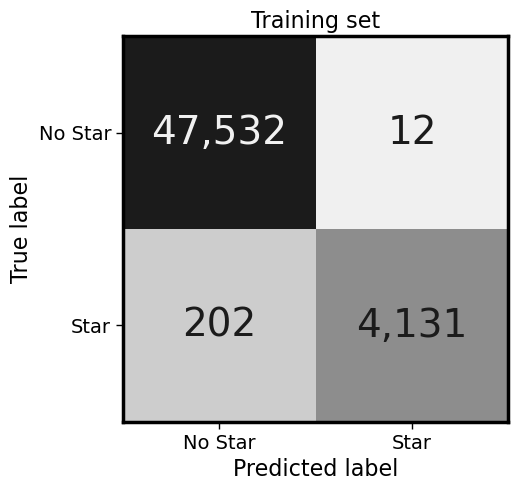

In [81]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

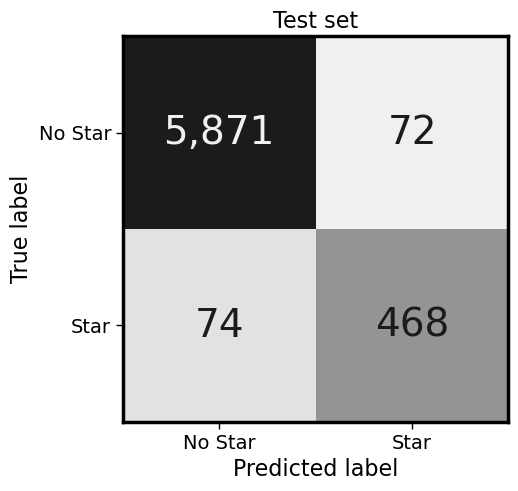

In [82]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

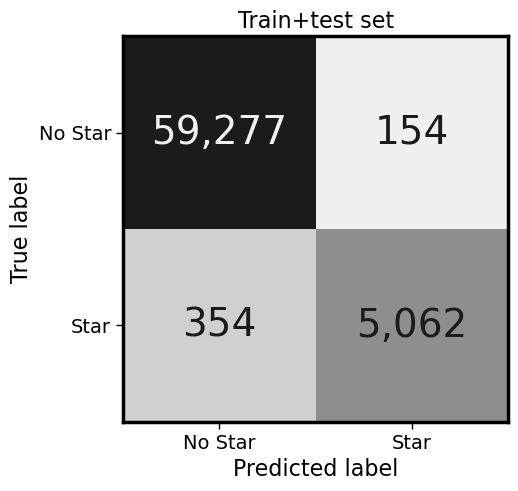

In [83]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

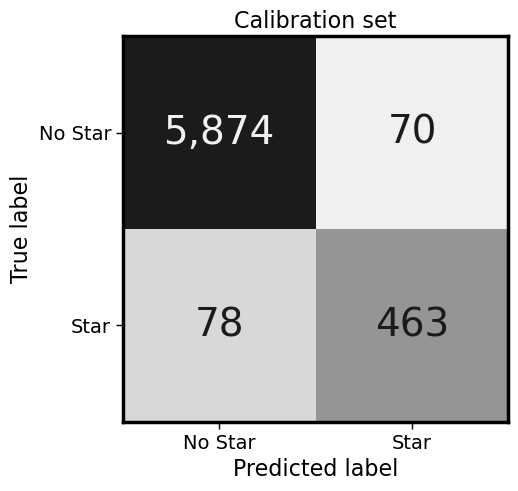

In [84]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

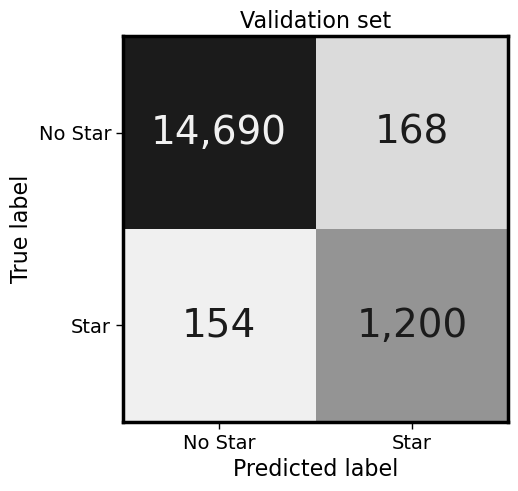

In [85]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

---

### Calibrate model and save it separately

In [86]:
print('Running data pre-processing for calibration (train+test):\n')
extended_calibration_df = gf.preprocess_data(final_str_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):



In [87]:
if save_model_flag:
    calibrated_final_str_clf = BetaCalibration(parameters='abm')
    calibrated_final_str_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_str_clf, gv.models_path + gv.cal_str_model)

In [88]:
if load_model_flag:
    calibrated_final_str_clf = load(gv.models_path + gv.cal_str_model)

In [89]:
train_prediction_clf['Prob_star']      = calibrated_final_str_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_star']       = calibrated_final_str_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_star'] = calibrated_final_str_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_star']      = calibrated_final_str_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_star'] = calibrated_final_str_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [90]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_star'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_star'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_star'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_star'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_star'], pos_label=1)

AUC for PR curve

In [91]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

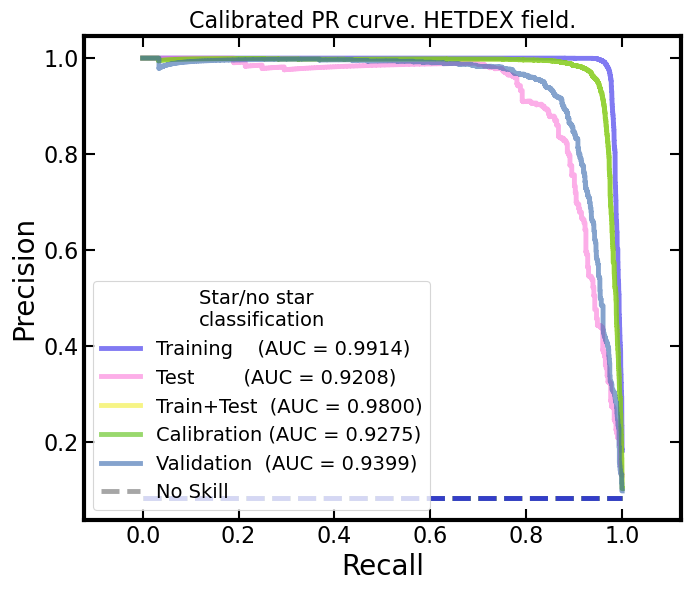

In [92]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Star/no star\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_str_no_str_01.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [93]:
fscore_train_cal      = (2 * prec_train_cal      * recall_train_cal)      / (prec_train_cal      + recall_train_cal)
fscore_test_cal       = (2 * prec_test_cal       * recall_test_cal)       / (prec_test_cal       + recall_test_cal)
fscore_train_test_cal = (2 * prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal + recall_train_test_cal)
fscore_calib_cal      = (2 * prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal      + recall_calib_cal)
fscore_validation_cal = (2 * prec_validation_cal * recall_validation_cal) / (prec_validation_cal + recall_validation_cal)

In [94]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [95]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.19613
Optimal threshold from Precision-Recall curve for test        = 0.30434
Optimal threshold from Precision-Recall curve for train+test  = 0.27261
Optimal threshold from Precision-Recall curve for calibration = 0.60073
Optimal threshold from Precision-Recall curve for validation  = 0.37870


In [96]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_star']      >= opt_t_PR_train_test_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_star']       >= opt_t_PR_train_test_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_star'] >= opt_t_PR_train_test_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_star']      >= opt_t_PR_train_test_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_star'] >= opt_t_PR_train_test_cal).astype(int)

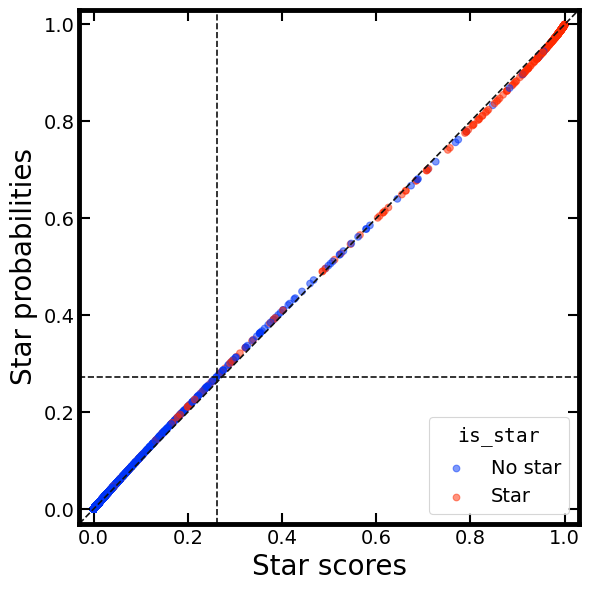

In [97]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, 'Prob_star'], marker='o',\
            alpha=0.5, c=calib_prediction_clf.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_train_test_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No star',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Star',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Star scores', size=20)
ax1.set_ylabel('Star probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{is\_star}$', title_fontsize=14)
ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

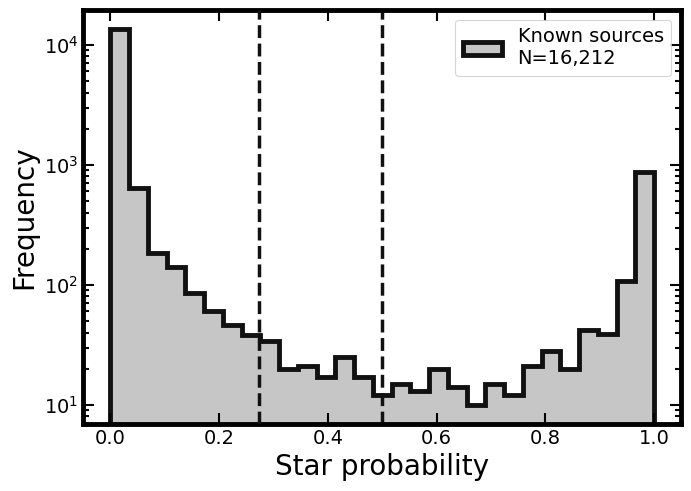

In [98]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(validation_prediction_clf.loc[:, 'Prob_star'])
max_score  = np.nanmax(validation_prediction_clf.loc[:, 'Prob_star'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(validation_prediction_clf.loc[:, 'Prob_star'])

ax1.hist(validation_prediction_clf.loc[:, 'Prob_star'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_train_test_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Star probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_str_cal_scores_known.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [99]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_star'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_star'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_star'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

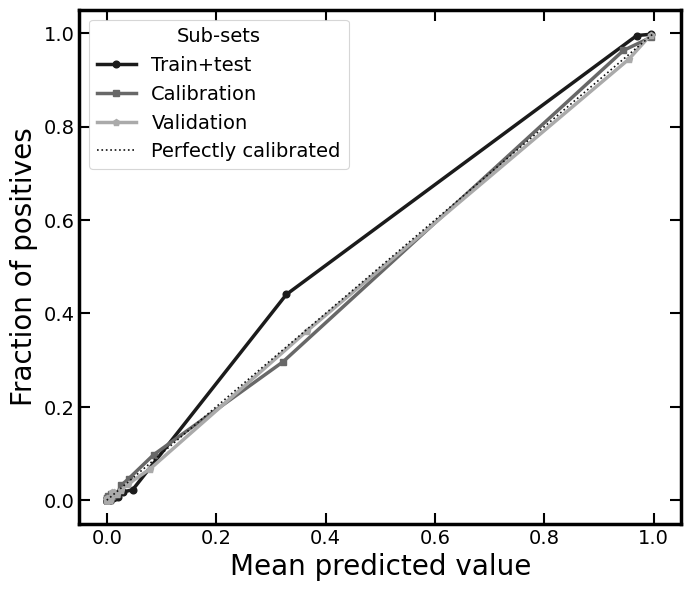

In [103]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_star_no_star.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).

If BSS $<0$, calibration was not succesful. If BSS $== 0$, it performs as the previous model.  
If BSS $>0$, calibration is useful and performs better than original model.

In [101]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [102]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is 0.000 using the validation set.
